In [48]:
%cd '/content/drive/MyDrive/Colab Notebooks/stepik/m4. inference/w4. tasks'

/content/drive/MyDrive/Colab Notebooks/stepik/m4. inference/w4. tasks


In [49]:
import warnings
warnings.filterwarnings('ignore')

In [50]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

Загрузим данные.

In [51]:
df = pd.read_csv('credit_card_default_analysis.csv')

Отцентрируем распределения выборок относительно их медиан

In [52]:
def centralize(df, flag):
    m = df.loc[df['default'] == flag, 'LIMIT_BAL'].median()
    df.loc[df['default'] == flag, 'LIMIT_BAL'] = df.loc[df['default'] == flag, 'LIMIT_BAL'] - m

centralize(df, 0)
centralize(df, 1)

total_sample = df['LIMIT_BAL']
sample1 = df[df['default'] == 0]['LIMIT_BAL']
sample2 = df[df['default'] == 1]['LIMIT_BAL']

Оценим применимость критерия согласия Пирсона

In [53]:
def is_chi2_applicable(ctable):
    chi2_stat, pvalue, _, expected_table = stats.chi2_contingency(ctable)
    less_than_five_cells = (expected_table < 5).sum()
    all_cells = expected_table.shape[0] * expected_table.shape[1]
    ratio = less_than_five_cells / all_cells
    print(ratio)
    return ratio < 0.2


In [54]:
quantiles = np.quantile(total_sample, np.linspace(0, 1, 101))
quantiles = list(set(quantiles))
quantiles.sort()
ctable = pd.DataFrame()
ctable['sample1'] = pd.cut(sample1, bins=quantiles).value_counts()
ctable['sample2'] = pd.cut(sample2, bins=quantiles).value_counts()
print('Тест на применимость критерия:', is_chi2_applicable(ctable))
stats.chi2_contingency(ctable)

0.0
Тест на применимость критерия: True


(5172.602688803996, 0.0, 42, array([[1925.95744681,  554.04255319],
        [ 994.04255319,  285.95744681],
        [1108.9787234 ,  319.0212766 ],
        [1477.08510638,  424.91489362],
        [ 809.21276596,  232.78723404],
        [ 834.06382979,  239.93617021],
        [ 845.71276596,  243.28723404],
        [ 775.04255319,  222.95744681],
        [ 674.08510638,  193.91489362],
        [ 629.04255319,  180.95744681],
        [ 545.17021277,  156.82978723],
        [ 621.27659574,  178.72340426],
        [ 459.74468085,  132.25531915],
        [ 731.55319149,  210.44680851],
        [ 607.29787234,  174.70212766],
        [ 643.79787234,  185.20212766],
        [ 605.74468085,  174.25531915],
        [ 557.59574468,  160.40425532],
        [ 531.96808511,  153.03191489],
        [ 817.75531915,  235.24468085],
        [ 441.88297872,  127.11702128],
        [1041.41489362,  299.58510638],
        [ 455.08510638,  130.91489362],
        [ 546.72340426,  157.27659574],
        [ 39

Сравним центрированные распределения, используя критерий Эппса-Синглтона

$H_0$: распределения центрированных выборок идентичны по форме

$H_1$: распределения центрированных выборок различны по форме

$alpha$ = 0.05

In [55]:
stats.epps_singleton_2samp(sample1, sample2)

Epps_Singleton_2sampResult(statistic=3073.550341883438, pvalue=0.0)

Вывод: достигаемый уровень значимости меньше $alpha$, нулевая гипотеза отвергается. Распределения различны по форме

Проведем визуальную оценку сходства распределений по форме c помощью qq-графика

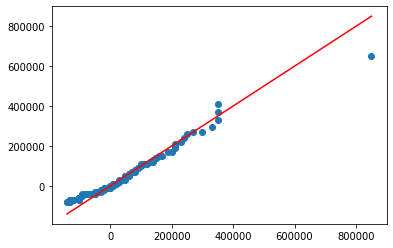

Коэффициент корреляции между квантилями распределений:  (0.9877118493625385, 1.2775138380354435e-81)


In [56]:
quantiles = np.linspace(0, 100, 101)
quantiles1 = np.percentile(sample1, quantiles)
quantiles2 = np.percentile(sample2, quantiles)
plt.scatter(quantiles1, quantiles2)
joined_sample = np.hstack([sample1, sample2])
limits = [np.min(joined_sample), np.max(joined_sample)]
plt.plot(limits, limits, c='r')
plt.show()
print('Коэффициент корреляции между квантилями распределений: ', stats.pearsonr(quantiles1, quantiles2))

Вывод: ближе к границам диапазона значений точки плохо ложатся на прямую, что говорит о различии распределений по форме.

Проведем визуальную оценку сходства распределений по форме, сопоставив графики эмпирических функций распределения

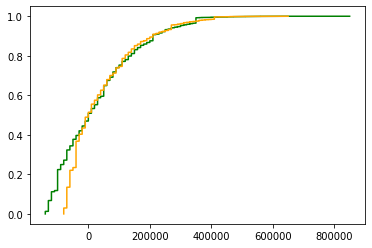

In [57]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf1 = ECDF(sample1)
ecdf2 = ECDF(sample2)
plt.plot(ecdf1.x, ecdf1.y, 'green')
plt.plot(ecdf2.x, ecdf2.y, 'orange')
plt.show()

Вывод: ближе к левой границе диапазона можно видеть разницу между эмпирическими функциями распределения.

Я исходила из того, что при наличии сдвига между распределениями можно сравнить их по форме, предварительно устранив этот сдвиг. Например, отцентрировав каждую выборку относительно ее медианы. 

Данные я считаю дискретными, так как выборки содержат большое число повторов. Критерий согласия Пирсона в данном случае не подходит, так как условия его применимости не выполняются. Критерий согласия Колмогорова-Смирнова в стандартной библиотечной реализации применим только при условии непрерывности данных. Судя по описанию критерия Эппса-Синглтона - он подходит. Его результат говорит о статистически значимом различии в распределениях выборок. 

Также я оценила сходство распределений графически, двумя способами: построив qq-график и сопоставив эмпирические функции распределения. На обоих графиках визуально прослеживаются различия в распределениях выборок, особенно ближе к левой границе диапазона. 

Вывод: распределения нельзя считать совпадающими по форме.

Я разбила диапазон значений на интервалы и составила таблицу сопряженности, посчитав для каждой выборки число значений в интервалах. Результат критерий согласия Пирсона свидетельствует о том, что централизованные выборки по форме различны.